In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from matplotlib import pyplot as plt
from scipy.stats import norm, truncnorm
from scipy.stats import lognorm
from scipy.stats import expon
from scipy.stats import nct
from scipy.stats import chi2
from scipy.stats import hypergeom
from tqdm import tqdm


### Length of conditional/hybrid CI 

In [2]:
def cond_CI_dist(gap, alpha=0.05, eps=1e-8, step=0.5):

    if gap < 0:
        print('gap must be positive')
        return 

    def obj(L):
        return norm.logsf(L) - (np.log(alpha) + norm.logsf(-1*gap + L))
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L
   

def hybrid_CI_dist(gap, n, alpha=0.05, beta=0.005, eps=1e-8, step=0.5):
    
    if gap < 0:
        print('gap must be positive')
        return 

    def B(alpha, n):
        return 1 - (1-alpha)**(1/n)
    
    def obj(L):
        return norm.logsf(L) - np.log( (alpha-beta)/(1-beta) * norm.sf(-1*gap + L) +  (1-alpha)/(1-beta)*B(beta, n) )
    
    L_lower = 0
    L_upper = 0
    obj_val = obj(L_upper)
    while obj_val > 0:
        L_upper += step
        obj_val = obj(L_upper)

    L = (L_lower + L_upper)/2

    while np.abs(L_upper - L_lower) > eps:
        obj_val = obj(L)
        if obj_val > 0:
            L_lower = L
            L = (L_lower + L_upper)/2
        if obj_val < 0:
            L_upper = L
            L = (L_lower + L_upper)/2

    return L




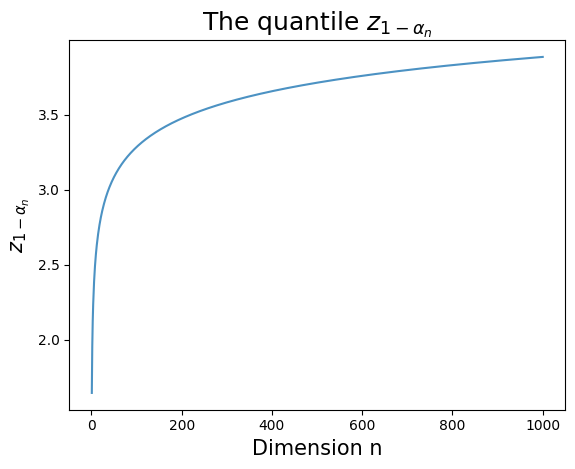

In [7]:
alpha = 0.05
alpha_ = 0.8

x = np.arange(1, 1001)
y = np.array([norm.ppf( (1-alpha) ** (1/i) ) for i in x ]) 

plt.figure()
plt.plot(x, y, alpha=alpha_)

plt.title(r"The quantile $z_{1 - \alpha_n}$", fontsize=18)
plt.xlabel("Dimension n", fontsize=15)
plt.ylabel(r"$z_{1 - \alpha_n}$", fontsize=15)

plt.grid(False)
plt.savefig(f"fig/class_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 373.26it/s]


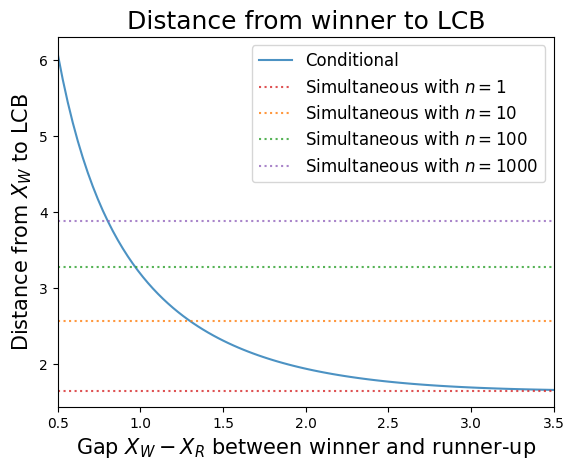

In [6]:
alpha = 0.05
alpha_ = 0.8
x_low = 0.5
x_hi = 3.5
x = np.linspace(x_low, x_hi, 100)
y = np.array([cond_CI_dist(gap) for gap in tqdm(x) ]) 

plt.figure()
plt.plot(x, y, label='Conditional', alpha=alpha_)

# Adding horizontal lines
plt.axhline(y=norm.ppf( (1-alpha) ), color='tab:red', linestyle='dotted', label='Simultaneous with $n=1$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/10) ) , color='tab:orange', linestyle='dotted', label='Simultaneous with $n=10$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/100) ), color='tab:green', linestyle='dotted', label='Simultaneous with $n=100$', alpha=alpha_)
plt.axhline(y=norm.ppf( (1-alpha) ** (1/1000) ), color='tab:purple', linestyle='dotted', label='Simultaneous with $n=1000$', alpha=alpha_)

plt.title("Distance from winner to LCB", fontsize=18)
plt.xlabel("Gap $X_{W} - X_{R}$ between winner and runner-up", fontsize=15)
plt.ylabel("Distance from $X_{W}$ to LCB", fontsize=15)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)
plt.savefig(f"fig/cond_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


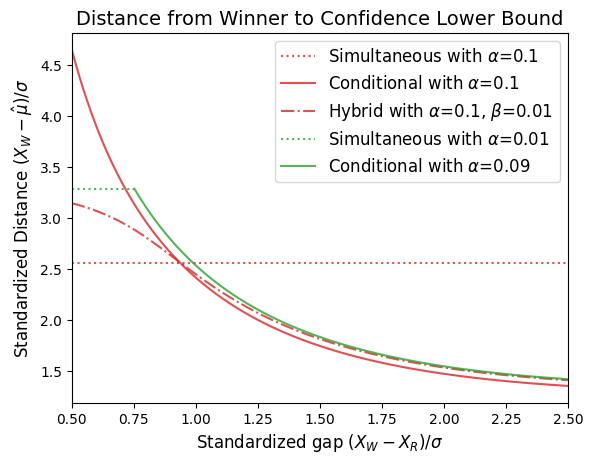

In [851]:
n = 20
alpha = 0.1
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Classical level alpha

plt.axhline(y=norm.ppf( (1-alpha) ** (1/n) ) , color='tab:red', linestyle='dotted', label=f'Simultaneous with $\\alpha$={alpha}', alpha=alpha_)


# Conditional level alpha 
plt.plot(x, np.array([cond_CI_dist(gap, alpha=alpha) for gap in x]), color='tab:red', label=f'Conditional with $\\alpha$={alpha}', alpha=alpha_)

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha, beta=beta) for gap in x]) , color='tab:red', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Simultaneous with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from Winner to Confidence Lower Bound", fontsize=14)
plt.xlabel("Standardized gap $(X_{W} - X_{R})/\sigma$", fontsize=12)
plt.ylabel("Standardized Distance $(X_{W} - \hat{\mu})/\sigma$ ", fontsize=12)
plt.xlim([x_low, x_hi ])

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig(f"fig/hyb_dist_to_winner.pdf", bbox_inches='tight', pad_inches=0)


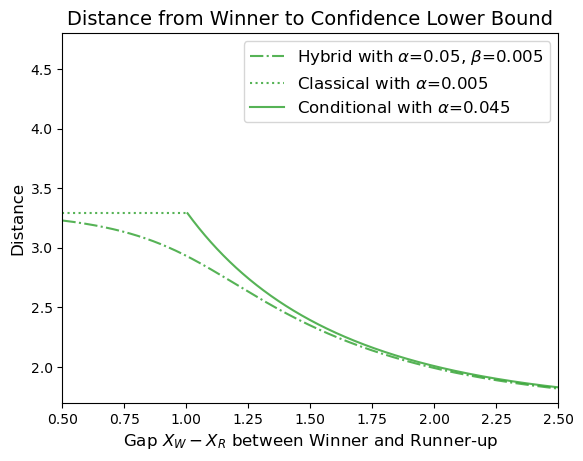

In [111]:
n = 10
alpha = 0.05
beta = alpha/10
alpha_ = 0.8
x_low = 0.5
x_hi = 2.5
x = np.linspace(x_low, x_hi, 1000)


plt.figure()

# Hybrid level alpha, beta 
plt.plot(x, np.array([hybrid_CI_dist(gap, n, alpha=alpha) for gap in x]) , color='tab:green', linestyle='-.', label=f'Hybrid with $\\alpha$={alpha}, $\\beta$={beta}' , alpha=alpha_)

cond_split = [cond_CI_dist(gap, alpha=alpha-beta) for gap in x]
for i in range(len(cond_split)):
    if cond_split[i] < norm.ppf( (1-beta) ** (1/n) ):
        break

# Classical level beta
plt.plot([x_low, x[i]], [norm.ppf( (1-beta) ** (1/n) ), norm.ppf( (1-beta) ** (1/n) )], color='tab:green', linestyle='dotted', label=f'Classical with $\\alpha$={beta}', alpha=alpha_)


## Conditional level alpha - beta 
plt.plot(x[i:], cond_split[i:], color = 'tab:green', label=f'Conditional with $\\alpha$={np.round(alpha-beta, 3)}', alpha=alpha_)

plt.title("Distance from Winner to Confidence Lower Bound", fontsize=14)
plt.xlabel("Gap $X_{W} - X_{R}$ between Winner and Runner-up", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.xlim([x_low, x_hi ])
plt.ylim(1.7, 4.8)

plt.legend(fontsize=12)

plt.grid(False)

plt.savefig(f"fig/hyb_dist_to_winner_n={n}.pdf", bbox_inches='tight', pad_inches=0)


<>:46: SyntaxWarning: invalid escape sequence '\h'
<>:46: SyntaxWarning: invalid escape sequence '\h'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_33830/1062092769.py:46: SyntaxWarning: invalid escape sequence '\h'
  tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']


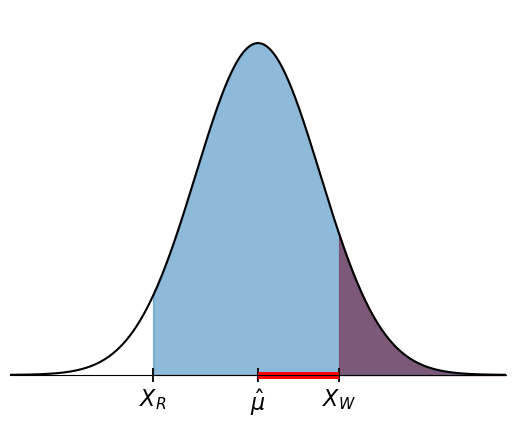

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 0.1
x_w = 0

key_to_x_r = {3 : -0.85, 2: -1.3, 1: -3}

key =  1
x_r = key_to_x_r[key]
mu = x_w - cond_CI_dist(x_w-x_r, alpha=alpha)
sigma = 1

fig, ax = plt.subplots(figsize=([6.4, 4.8]))

# Adjust the bottom spine (x-axis) to start at y=shift
shift = 0.005
plt.gca().spines['bottom'].set_position(('data', 0.005))
plt.gca().spines['bottom'].set_color('black')  # Optional: keep the x-axis visible

# Generate x values
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
# Generate y values based on the Gaussian distribution
y_values = norm.pdf(x_values, mu, sigma) + shift

# Plot the Gaussian distribution
plt.plot(x_values, y_values, color='black')

# Shade the area under the curve to the right of x_w
x_fill = np.linspace(x_w, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.9, color='tab:red')

# Shade the area under the curve to the right of x_r
x_fill = np.linspace(x_r, mu + 4*sigma, 1000)
y_fill = norm.pdf(x_fill, mu, sigma) + shift
plt.fill_between(x_fill, y_fill, y2=shift, alpha=0.5, color='tab:blue')

# Remove the top, right, and left spines (box outline)
for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)


tick_positions = [mu, x_w, x_r]  
tick_labels = ['$\hat{\mu}$', '$X_W$', '$X_R$']  
plt.xticks(tick_positions, tick_labels, fontsize=16)
plt.yticks([])
ax.tick_params(axis='x', length=10, width=1.3, direction='inout', colors='black') 

correction=0.115
plt.plot([mu + correction, x_w - correction], [0, 0], color='#FF0000', linewidth=10)


# Adjust the limits to ensure annotations are visible
x_dist = x_w - min(mu, x_r)
#plt.xlim([-6, 2.4])
plt.xlim([mu - 4*sigma, mu + 4*sigma])
plt.ylim([0, max(y_values) * 1.1])

plt.savefig(f"fig/tail_prob_{key}.pdf", bbox_inches='tight', pad_inches=0)

# Show plot
plt.show()


### Hybrid Simulations

In [426]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

In [427]:
def union_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    class_reject = ps[:, 0] < B(beta, n)
    cond_reject = ps[:, 0] < (alpha - beta) * ps[:, 1]
    reject = np.logical_or(class_reject, cond_reject)
    return reject

def hybrid_reject(ps, alpha, beta):
    n = ps.shape[1]
    ps = np.sort(ps, axis=1)
    reject = ps[:, 0] < B(beta, n) + (alpha-beta)/(1-beta) * (ps[:, 1] - B(beta, n)) 
    return reject


<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_3672/3788381055.py:42: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu_1$", fontsize=16)


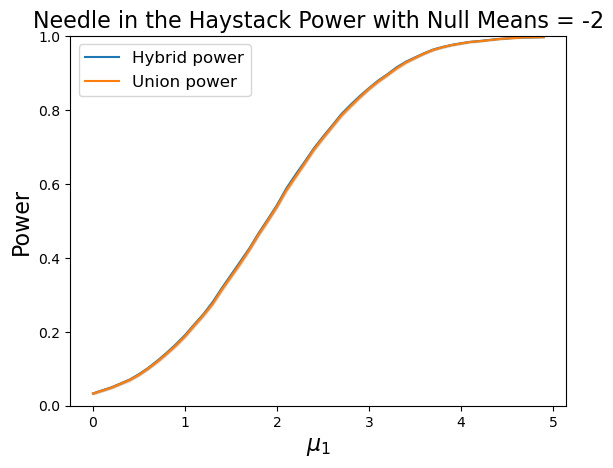

In [434]:
alpha = 0.05
beta = alpha/10
n = 10
mu1s = np.arange(0, 5, step=0.1)
mu2 = -2
sigma = np.ones(n)
sigma[0]=1
sigma[1:]=1

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = []
union_power = []
class_power = []

for i in range(len(mu1s)):
        mu1 = mu1s[i] 
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1:] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :]) 
        hybrid_power.append(np.mean(hybrid_reject(ps, alpha, beta)))
        union_power.append(np.mean(union_reject(ps, alpha, beta)))

hybrid_power = np.array(hybrid_power)
union_power = np.array(union_power)

hybrid_std_dev = np.sqrt(hybrid_power * (1 - hybrid_power) / N)
hybrid_upper_bound = hybrid_power + hybrid_std_dev
hybrid_lower_bound = hybrid_power - hybrid_std_dev
plt.plot(mu1s, hybrid_power, label='Hybrid power', color='tab:blue')
plt.fill_between(mu1s, hybrid_lower_bound, hybrid_upper_bound, color='tab:blue', alpha=0.3)    

union_std_dev = np.sqrt(union_power * (1 - union_power) / N)
union_upper_bound = union_power + union_std_dev
union_lower_bound = union_power - union_std_dev
plt.plot(mu1s, union_power, label='Union power', color='tab:orange')
plt.fill_between(mu1s, union_lower_bound, union_upper_bound, color='tab:orange', alpha=0.3)    

plt.xlabel("$\mu_1$", fontsize=16)
plt.ylabel("Power", fontsize=16)
plt.title(f"Needle in the Haystack Power with Null Means = {mu2}", fontsize=16)

plt.legend(fontsize=12)
plt.ylim([0, 1])

plt.savefig(f"fig/hybrid_vs_union_null={mu2}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [250]:
alpha = 0.05
beta = alpha/10
mus = np.arange(-3, 3.1, step=0.1)
sigma = np.ones(n)
sigma[0]=2
sigma[1]=1/2

N, n_max = 10000, 10

X = np.random.normal(0, 1, (N, n_max)) * sigma[np.newaxis, :]

hybrid_power = {}
union_power = {}

for i in range(len(mus)):
    for j in range(i + 1):
        mu1, mu2 = mus[i], mus[j]
        if mu1 < 0.01:
            continue
        X_ = X.copy()
        X_[:, 0] += mu1
        X_[:, 1] += mu2
        ps = 1 - norm.cdf(X_ * 1/sigma[np.newaxis, :])
        ps[:, 2:] = 1
        hybrid_power[(mu1, mu2)] = np.mean(hybrid_reject(ps, alpha, beta))
        union_power[(mu1, mu2)] = np.mean(union_reject(ps, alpha, beta))




0.02859999999999996
0.0025000000000000022
0.014600000000000035
1395


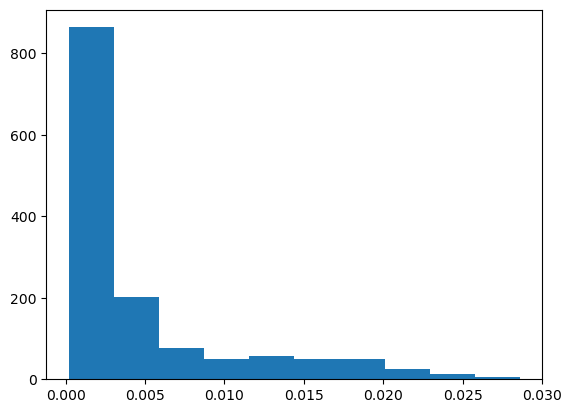

In [251]:
diffs = []
for key in union_power:
    diffs.append(hybrid_power[key] - union_power[key])
plt.hist(diffs)
print(np.max(diffs))
print(np.median(diffs))
print(np.quantile(diffs, 0.9))
print(len(diffs))

### Hybrid Real Data 

In [738]:
means = np.array([2093, 6547, -1417, 785, 1343, 401, -1325, 485, 336, -121, 904, 1424, -1370])

stds = np.array([2280.40, 1496.17, 2168.21, 1681.92, 1735.51, 1329.05, 1598.03, 971.05, 1523.33, 1409.79, 1814.10, 1768.44, 1860.45])

In [736]:
n=1000
n_sig = 10

means = np.concatenate([np.full(n_sig, 2), np.full(n-n_sig, -2)])
stds = np.ones(len(means))

In [739]:
def sample_hybrid_data(real=True): 
    if real:
        v = 0
    else:
        v = 1
    n = len(means)
    X = means + np.random.normal(0, v, size=n) * stds
    Z = np.random.normal(0, 1, size=n) * stds
    X1 = X + Z
    X2 = X - Z
    return X, X1, X2

In [737]:
N=1000
alpha = 0.05
beta = alpha/10

def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

simul_reject = 0
split_reject = 0
hybrid_reject = 0 
carve_reject = 0 
cond_reject = 0

def integrand(x, t, W_tilde):
    return 1 - norm.cdf(t/stds[W_tilde] - norm.ppf(1-x))

for i in tqdm(range(N)):
    X, X1, X2 = sample_hybrid_data(real=False)
    W = np.argmax(X/stds)
    W_tilde = np.argmax(X1/stds)
    ps = 1 - norm.cdf(X/stds)
    p2s = 1 - norm.cdf((X2/np.sqrt(2))/stds)

    alpha_n = B(alpha, n)
    beta_n = B(beta, n)
    cond_reject += (ps[W] < alpha * np.sort(ps)[1])
    simul_reject += (ps[W] < alpha_n)
    split_reject += (p2s[W_tilde] < alpha)
    
    q = np.sort(ps)[1]
    hybrid_reject += (ps[W] <= (alpha-beta)/(1-beta) * q + (1-alpha)/(1-beta) * beta_n)

    p_combined = 1 - norm.cdf( ( (X1[W_tilde] + X2[W_tilde])/2)/stds[W]) 
    ts = stds[W_tilde]/stds * X1
    ts[W_tilde] = -np.inf
    t = np.max(ts)
    num, error = integrate.quad(integrand, 0, p_combined, args=(t, W_tilde,))
    den, error = integrate.quad(integrand, 0, 1, args=(t, W_tilde,) )
    p_sel = num/den
    carve_reject += (p_sel <= alpha)

print('Conditional power ', cond_reject/N)
print('Simultaneous power ', simul_reject/N)
print('Split power ', split_reject/N)
print('Hybrid power ', hybrid_reject/N)
print('Carve power ', carve_reject/N)


100%|██████████| 1000/1000 [00:35<00:00, 28.01it/s]

Conditional power  0.203
Simultaneous power  0.24
Split power  0.384
Hybrid power  0.221
Carve power  0.428


In [748]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

def simul_lcb(X, alpha=0.1):
    n = len(X)
    lcbs = X - stds * norm.ppf(1 - B(alpha, n))
    W = np.argmax(X)
    return lcbs[W]


def split_lcb(X1, X2, alpha=0.1):
    lcbs = X2 - np.sqrt(2) * stds * norm.ppf(1 - alpha)
    W = np.argmax(X1/stds)
    return lcbs[W]

def hybrid_lcb(X, alpha=0.1, beta=0.01, mu_guess=0, eps=1e-6, step=1000):
    
    W = np.argmax(X/stds)
    n=len(X)
    beta_n = B(beta, n)
    
    def compute_q(mu_0):
        return 1 - norm.cdf(X/stds - mu_0/stds[W]) 
    
    def obj(mu_0):
        qs = compute_q(mu_0)
        qs[W] = np.inf
        q = np.min(qs)
        p = 1 - norm.cdf((X[W] - mu_0)/stds[W])
        return p - (alpha-beta)/(1-beta) * q - (1-alpha)/(1-beta) * beta_n

    lower_guess = mu_guess 
    upper_guess = mu_guess 

    lower_obj_val = obj(lower_guess)

    while lower_obj_val > 0:
        lower_guess -= step
        lower_obj_val = obj(lower_guess)
 
    upper_obj_val = obj(upper_guess)
    while upper_obj_val < 0:
        upper_guess += step
        upper_obj_val = obj(upper_guess)

    middle_guess = (lower_guess + upper_guess)/2

    while np.abs(upper_guess - lower_guess) > eps:
        obj_val = obj(middle_guess)
        if obj_val < 0:
            lower_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2
        if obj_val > 0:
            upper_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2

    return lower_guess


def carving_lcb(X1, X2, alpha=0.1, mu_guess=0, eps=1e-6, step=1000):
    
    W = np.argmax(X1/stds)
    n=len(X1)

    ts = stds[W]/stds * X1
    ts[W] = -np.inf
    t = np.max(ts)

    def obj(mu_0):
        p1 = 1 - norm.cdf( (X1[W] - mu_0)/(np.sqrt(2) * stds[W] ) )
        p2 = 1 - norm.cdf( (X2[W] - mu_0)/(np.sqrt(2) * stds[W]))
        qs = 1 - norm.cdf(X/(np.sqrt(2) * stds) - mu_0/(np.sqrt(2)* stds[W] ) ) 
        qs[W] = np.inf
        q = np.min(qs)
        return 2*(np.log(p1/q) + np.log(p2)) + chi2.ppf(1-alpha, df=4)

    lower_guess = mu_guess 
    upper_guess = mu_guess 
    lower_obj_val = obj(lower_guess)
    while lower_obj_val > 0:
        lower_guess -= step
        lower_obj_val = obj(lower_guess)
 
    upper_obj_val = obj(upper_guess)
    while upper_obj_val < 0:
        upper_guess += step
        upper_obj_val = obj(upper_guess)

    middle_guess = (lower_guess + upper_guess)/2

    while np.abs(upper_guess - lower_guess) > eps:
        obj_val = obj(middle_guess)
        if obj_val < 0:
            lower_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2
        if obj_val > 0:
            upper_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2

    return lower_guess



In [749]:
def carving_lcb(X1, X2, alpha=0.1, mu_guess=0, eps=1e-6, step=1000):
    
    W = np.argmax(X1/stds)
    n=len(X1)

    ts = stds[W]/stds * X1
    ts[W] = -np.inf
    t = np.max(ts)
    
    def compute_p(mu_0):
        return 1 - norm.cdf( ( (X1[W] + X2[W])/2  - mu_0)/stds[W]) 
    
    def compute_p_adj(mu_0):

        def integrand(x):
            return 1 - norm.cdf( (t - mu_0)/stds[W] - norm.ppf(1-x)) 
        
        p = compute_p(mu_0)
        num, error = integrate.quad(integrand, 0, p)
        den, error = integrate.quad(integrand, 0, 1)
        return num/den

    def obj(mu_0):
        return compute_p_adj(mu_0) - alpha 

    lower_guess = mu_guess 
    upper_guess = mu_guess 
    lower_obj_val = obj(lower_guess)
    while lower_obj_val > 0:
        lower_guess -= step
        lower_obj_val = obj(lower_guess)
 
    upper_obj_val = obj(upper_guess)
    while upper_obj_val < 0:
        upper_guess += step
        upper_obj_val = obj(upper_guess)

    middle_guess = (lower_guess + upper_guess)/2

    while np.abs(upper_guess - lower_guess) > eps:
        obj_val = obj(middle_guess)
        if obj_val < 0:
            lower_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2
        if obj_val > 0:
            upper_guess = middle_guess
            middle_guess = (lower_guess + upper_guess)/2

    return lower_guess

In [716]:
N=1000
alpha = 0.05
n = 100

X1 = np.random.normal(0, 1, size=(N, n)) * np.sqrt(2) 
X2 = np.random.normal(0, 1, size=(N, n)) * np.sqrt(2) 

def integrand(x, t):
        return 1 - norm.cdf(t - norm.ppf(1-x)) 

W = np.argmax(X1, axis=1)
p = 1 - norm.cdf((X1[np.arange(N), W] + X2[np.arange(N), W])/2)
p2 = 1 - norm.cdf(X2[np.arange(N), W]/np.sqrt(2))
X1_sorted = np.sort(X1, axis=1)
ts = X1_sorted[:, n-2]
p_adj = np.zeros(N)

for i in tqdm(range(N)):
    num, error = integrate.quad(integrand, 0, p[i], args=(ts[i],))
    den = 1 - norm.cdf(ts[i]/np.sqrt(2))
    p_adj[i] = num/den

print('Split', np.mean(p2 < alpha))
print('Carve', np.mean(p_adj < alpha))

100%|██████████| 1000/1000 [00:17<00:00, 57.66it/s]

Split 0.055
Carve 0.057


100%|██████████| 1000/1000 [00:04<00:00, 237.73it/s]
10it [02:04, 12.42s/it]


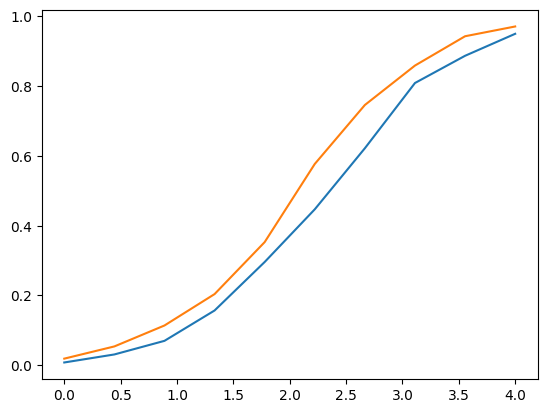

In [677]:
N=1000
alpha = 0.05
mus = np.linspace(0, 4, 10)

def integrand(x, t):
        return 1 - norm.cdf(t - norm.ppf(1-x)) 

split_power = np.zeros(len(mus))
carve_power = np.zeros(len(mus))
for i, mu in tqdm(enumerate(mus)):
    sigma = np.sqrt(2)  # standard deviation
    lower_bound = 2  # truncation from below

    # Calculate the a and b for the truncnorm function
    a = (lower_bound - mu) / sigma
    b = np.inf
    X1 = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=N)
    X2 = np.random.normal(mu, 1, size=N)
    p = 1 - norm.cdf( (X1 + X2)/2 )
    p_adj = np.zeros(N)
    for j in tqdm(range(N)):
        num, error = integrate.quad(integrand, 0, p[j], args=(lower_bound,))
        den = 1 - norm.cdf(lower_bound/np.sqrt(2))
        p_adj[j] = num/den
    p2 = 1 - norm.cdf(X2/np.sqrt(2))
    split_power[i] = np.mean(p2 < alpha)  
    carve_power[i] = np.mean(p_adj < alpha)

plt.plot(mus, split_power, label='split') 
plt.plot(mus, carve_power, label='carve') 

In [750]:
N = 100

hybrid_lcbs = np.zeros(N)
split_lcbs = np.zeros(N)
carve_lcbs = np.zeros(N)
simul_lcbs = np.zeros(N)

for i in tqdm(range(N)):
    X, X1, X2 = sample_hybrid_data(real=True)
    simul_lcbs[i] = simul_lcb(X)
    split_lcbs[i] = split_lcb(X1, X2)
    hybrid_lcbs[i] = hybrid_lcb(X, step=1000, mu_guess=0)
    carve_lcbs[i] = carving_lcb(X1, X2, step=1000, mu_guess=0)

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


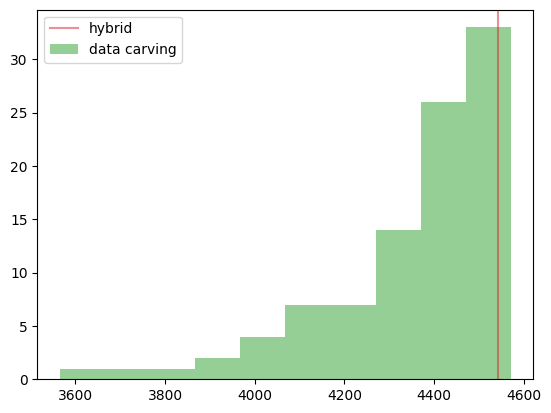

In [759]:
plt.axvline(hybrid_lcbs[0], label='hybrid', alpha=0.5, color='tab:red') 
#plt.hist(split_lcbs, label='data splitting', alpha=0.5, color='tab:blue', density=True)
plt.hist(carve_lcbs[np.where(carve_lcbs > 0) ], label='data carving', alpha=0.5, color='tab:green', bins=10) 
#plt.hist(simul_lcbs, label='simultaneous', alpha=0.5, color='tab:purple', density=True)
plt.legend()

In [764]:
alpha =0.05
print(1 - norm.cdf(np.sqrt(2) * norm.ppf(1-alpha)))
x = norm.ppf(1-alpha)
print(1 - norm.cdf(x/np.sqrt(2)))

0.01000462685805903
0.12239707182667492


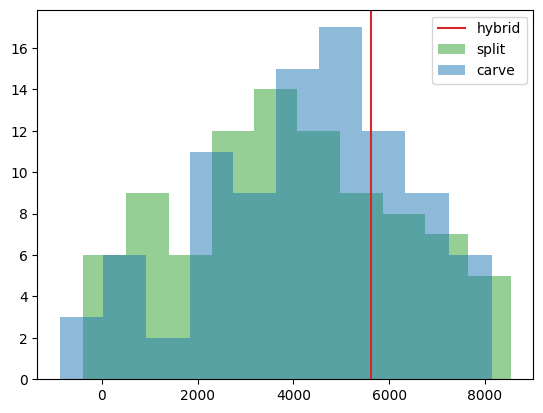

In [499]:
# Filter out values below -1000 from each data set
split_lcbs_filtered = [x for x in split_lcbs if x >= -1000]
carve_lcbs_filtered = [x for x in carve_lcbs if x >= -1000]
hybrid_lcbs_filtered = [x for x in hybrid_lcbs if x >= -1000]

# Now plot the filtered data
plt.axvline(hybrid_lcbs_filtered[0], label='hybrid', color='tab:red')
plt.hist(split_lcbs_filtered, label='split', alpha=0.5, color='tab:green') 
plt.hist(carve_lcbs_filtered, label='carve', alpha=0.5, color='tab:blue', bins=10) 
plt.legend()

In [206]:
X2 - np.sqrt(2) * stds * stds * norm.ppf(1 - B(alpha, 13))

TypeError: 'int' object is not callable

In [194]:
mu_hybrid

4555.709301649593

In [193]:
mu_carve

4544.982265797444

In [162]:
alpha = 0.1
beta = alpha/10
beta_n = B(alpha, len(X))
qs = 1 - norm.cdf(X/stds - mu_0/stds[1])
print(qs) 
print( (qs[1] - beta_n)/(np.max(qs) - beta_n), (alpha-beta)/(1-beta))

[0.98329381 0.09160677 0.99989154 0.99503397 0.98842888 0.99695777
 0.99994648 0.99454323 0.99763113 0.99912818 0.99456103 0.9874443
 0.99992199]
0.09090909086425707 0.09090909090909093


In [145]:
norm.ppf(1 - B(0.1, len(X)))

np.float64(2.4056482173652736)

In [144]:
X2[1] -  np.sqrt(2) * stds[1] * norm.ppf(1 - B(0.1, len(X)))

np.float64(-824.6790410074736)

In [94]:
split_lcb(X1, X2)

np.float64(7483.106627545961)

In [89]:
print(X[1], X1[1])

6547.0 5224.131803672098


In [59]:
def hybrid_lcb(X):
    

[ 2093.  6547. -1417.   785.  1343.   401. -1325.   485.   336.  -121.
   904.  1424. -1370.]


In [64]:
def split_lcb(X1, X2, alpha=0.1):
    n = len(X2)
    lcbs = X2 - norm.ppf(1 - B(alpha, n))
    W = np.argmax(X1/stds)
    return lcbs[W]

### Rank Verification and Randomization

In [858]:
# X ~ Bin(n, p1)
# Y ~ Bin(n, p2)


#test null that p1 <= p2
def binom_p_val(b, X, Y):

  num_tests = len(X)

  U = np.random.uniform(0, 1, size=num_tests)
  total=2*b
  successes=X+Y
  drawn=b

  p_val_lower = 1 - hypergeom.cdf(X, M=total, n=successes, N=drawn)
  p_val_upper = 1 - hypergeom.cdf(X - 1, M=total, n=successes, N=drawn)

  return p_val_lower + U*(p_val_upper - p_val_lower)

In [855]:
num_tests = int(1e7)
b = 4
p= 0.5
X = hypergeom.rvs(M=2*b, n=b, N=b, size=num_tests)
Y = b - X

In [856]:
n = 3
winners = np.where(X > int(b/2))[0]
winners_ = np.where(X == int(b/2) )[0]
mask = np.array(np.random.binomial(1, 1/n, size=len(winners_)), dtype=bool)
winners_ = winners_[mask]
all_winners = np.concatenate([winners, winners_])

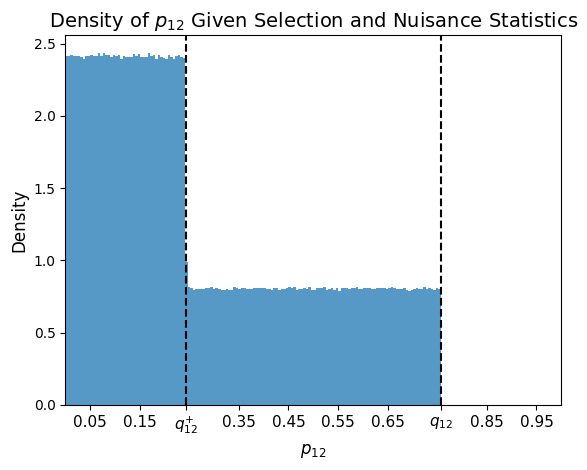

In [860]:
ps = binom_p_val(b, X[all_winners], Y[all_winners])
plt.hist(ps, bins=150, density=True, color='tab:blue', alpha=0.75)
q_plus = 1 - hypergeom.cdf(int(b/2), M=2*b, n=b , N=b)
q = 1 - hypergeom.cdf(int(b/2) - 1, M=2*b, n=b , N=b)
plt.title("Density of $p_{12}$ Given Selection and Nuisance Statistics", fontsize=14)
plt.ylabel("Density", fontsize=12)
plt.xlabel("$p_{12}$", fontsize=12)
plt.axvline(q, linestyle='--', color='black') 
plt.axvline(q_plus, linestyle='--', color='black') 


tick_positions = list(np.round(np.arange(0.05, 1.05, step=0.1), 2))
tick_positions.remove(0.25)
tick_positions.remove(0.75)
tick_labels = tick_positions.copy()

tick_positions += [q_plus, q]  
tick_labels += ['$q^{+}_{12}$', '$q_{12}$']  
plt.xticks(tick_positions, tick_labels, fontsize=11)

plt.xlim([0, 1])

plt.savefig(f"fig/p_val_density.pdf", bbox_inches='tight', pad_inches=0)

fig = plt.gcf()
figsize = fig.get_size_inches()


In [492]:
b=4
num_tests = int(1e5)
n=3
alpha = 0.1
B = np.random.binomial(b, 0.5, size=(num_tests, n))

num_winners = np.sum(B == np.max(B, axis=1).reshape(num_tests, 1), axis=1)
winners = np.argmax(B, axis = 1) 
selected = np.where(winners == 0)[0]
num_winners = num_winners[selected]
randomly_selected = np.random.binomial(1, 1/num_winners)
selected = selected[randomly_selected == 1]
num_winners = num_winners[randomly_selected == 1]
B = B[selected, :]


N = 1 + np.sum(B[: , 1:] == np.max(B[: , 1:], axis=1).reshape(len(B), 1), axis=1)
Y = B[:, 1]
X = B[:, 0]

ps = binom_p_val(b, X, Y)

cutoffs = (X + Y)/2
if n > 2:
    cutoffs = np.maximum(cutoffs, np.max(B[:, 2:], axis=1))

q_pluses = np.zeros(len(cutoffs))
qs = np.zeros(len(cutoffs))

not_integer = np.where(cutoffs != np.round(cutoffs))[0]
integer = np.where(cutoffs == np.round(cutoffs))[0]

q_pluses = 1 - hypergeom.cdf(cutoffs - 1, M=2*b, n=X+Y , N=b)

if len(not_integer) > 0:
    q_pluses[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)
    qs[not_integer] = 1 - hypergeom.cdf(np.floor(cutoffs[not_integer]), M=2*b, n=(X+Y)[not_integer] , N=b)

if len(integer) > 0:
    q_pluses[integer] = 1 - hypergeom.cdf(cutoffs[integer], M=2*b, n=(X+Y)[integer] , N=b)
    qs[integer] = 1 - hypergeom.cdf(cutoffs[integer] - 1, M=2*b, n=(X+Y)[integer], N=b)

fithian_ps = ps/qs 
my_ps = (ps - (1 - 1/N) * np.maximum(ps - q_pluses, 0))/(q_pluses + 1/N * (qs - q_pluses))



In [493]:
alpha = 0.1
fithian_error = np.mean(fithian_ps < alpha)
my_error = np.mean(my_ps < alpha)
fithian_se = np.sqrt((fithian_error * (1- fithian_error))/len(my_ps))
my_se = np.sqrt((my_error * (1- my_error))/(len(my_ps)))


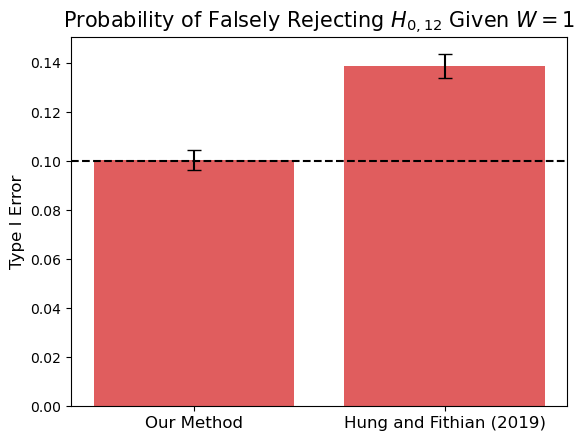

In [495]:

bar_heights = [my_error, fithian_error]
error_heights = [norm.ppf(1 - 0.01/2)*my_se, norm.ppf(1 - 0.01/2)*fithian_se]
bar_labels = ["Our Method", "Hung and Fithian (2019)"]

x_positions = np.arange(len(bar_heights))

plt.figure(figsize=figsize) 
plt.bar(x_positions, bar_heights, yerr=error_heights, capsize=5, color='tab:red', alpha=0.75)
plt.xticks(x_positions, bar_labels, fontsize=12) 

plt.axhline(y=alpha, color='black', linestyle='--')

plt.ylabel("Type I Error", fontsize=12)
plt.title("Probability of Falsely Rejecting $H_{0, 12}$ Given $W=1$", fontsize=15)

plt.savefig(f"fig/type_one_error.pdf", bbox_inches='tight', pad_inches=0)

### Rank Verification Warm-up Plot

In [802]:
b = 1000
mu1s = np.linspace(-3, 3, b)
mu2 = 0
alpha=0.1

inequality_error = np.zeros(b)
equality_error = np.zeros(b)

for i, mu1 in enumerate(mu1s):
    inequality_error[i] = (1 - norm.cdf(norm.ppf(1-alpha) + (mu1 - mu2))) * (mu1 > mu2) + (1 - norm.cdf(norm.ppf(1-alpha) + (mu2 - mu1))) * (mu2 > mu1) 
    equality_error[i] = (1 - norm.cdf(norm.ppf(1-alpha) + (mu1 - mu2))) * (mu1 >= mu2) + (1 - norm.cdf(norm.ppf(1-alpha) + (mu2 - mu1))) * (mu2 >= mu1) 

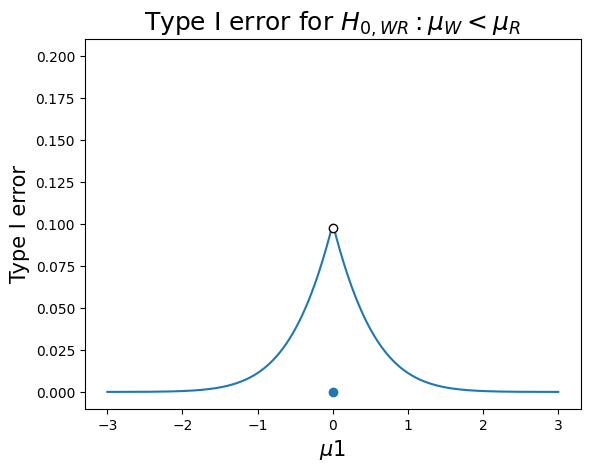

In [836]:

plt.plot(mu1s, inequality_error) 
plt.plot()
plt.xlabel("$\mu1$", fontsize=15)
plt.ylabel("Type I error", fontsize=15)
plt.plot(0, alpha-0.0025, 'o', color='white', markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.scatter(0, 0, )
plt.title("Type I error for $H_{0, WR} : \mu_W < \mu_R$", fontsize=18)
plt.ylim([-0.01, 0.21])
plt.savefig(f"fig/inequality_error.pdf")

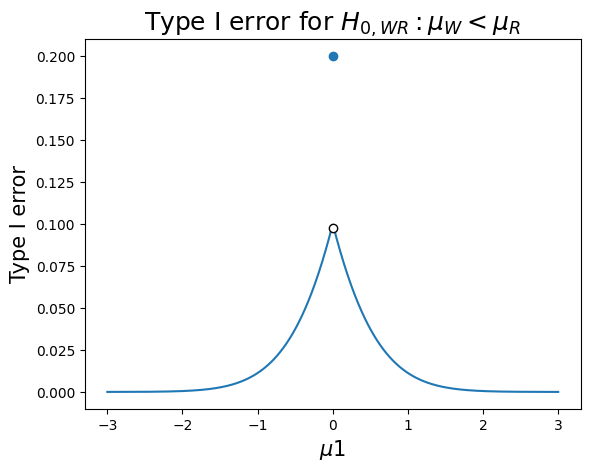

In [837]:

plt.plot(mu1s, equality_error) 
plt.plot()
plt.xlabel("$\mu1$", fontsize=15)
plt.ylabel("Type I error", fontsize=15)
plt.plot(0, alpha-0.0025, 'o', color='white', markersize=6, markeredgecolor='black', markeredgewidth=1)
plt.scatter(0, 2*alpha)
plt.title("Type I error for $H_{0, WR} : \mu_W < \mu_R$", fontsize=18)
plt.ylim([-0.01, 0.21])
plt.savefig(f"fig/equality_error.pdf")

### Rank Verification Stuff

In [125]:
N = 10000
n = 5

fithian_p = np.zeros(N)
my_p = np.zeros((N, n-1)) 
mu = np.zeros(n)
mu[0] = 2

for i in range(N):

    X = np.random.normal(0, 1, size=n) + mu
    order = np.argsort(X)
    X = X[order]
    diffs = X.reshape(-1, 1) - X.reshape(1, -1)  
    ps = 1 - norm.cdf(diffs/np.sqrt(2))
    fithian_p[i] = ps[n-1, n-2] * 2
    for j in range(n - 1):
        p = ps[-1, j]
        avg = (X[n-1] + X[j])/2 
        exclude_indices = [j, n-1]
        X_rem = np.delete(X, exclude_indices)

        # find lower bound on for (X_1 - X_j)/2
        lb1 = 0 
        lb2 = np.max(X_rem) - avg

        lb3 = -1*np.inf
        if len(X[(j+1):(n-1)]) > 0:
            lb3 = avg - np.min(X[(j+1):(n-1)])
        lb = max(lb1, lb2, lb3)

        # find upper bound on for (X_1 - X_j)/2
        ub = np.inf
        if len(X[:j]) > 0:
            ub = avg  - np.max(X[:j]) 


        # find lower and upper bound for p 
        p_upper = 1 - norm.cdf(lb * np.sqrt(2))
        p_lower = 1 - norm.cdf(ub * np.sqrt(2))

        if not p_lower < p and p < p_upper:
            print('issue')

        p_adj = (p - p_lower)/(p_upper - p_lower)
        my_p[i, j] = p_adj

fithian_power = np.mean(fithian_p < 0.05) 
my_power = np.mean(np.max(my_p, axis=1) < 0.05) 
my_power = np.mean(my_p[:, -1] < 0.05) 


print(fithian_power, my_power)

### Randomized Selection

In [1]:
def f(x, u, other_ps, gamma):
    probs = 1 - (gamma/(1-gamma) * (x - other_ps) + u)
    probs = np.minimum(np.maximum(0, probs), 1)
    if np.any(probs == 0):
        return 0
    return np.exp(np.sum(np.log(probs)))

def p_adj(p, other_ps, gamma):
    num = integrate.dblquad(f, a=0, b=1, gfun=0, hfun=p, args=(other_ps, gamma))[0]
    den = integrate.dblquad(f, a=0, b=1, gfun=0, hfun=1, args=(other_ps, gamma))[0]
    return num/den

In [3]:
N = 1000
n=10
gamma = 1/2
ps = np.random.uniform(0, 1, size=n)
select = 0
us = np.zeros(n)
us[0] = np.random.uniform(0, 1)

for i in range(N):
    us[1:] = np.random.uniform(0, 1, size=n-1)
    qs = gamma * ps + (1 - gamma) * us 
    if np.argmin(qs) == 0:
        select += 1

print(select/N)
print(f(ps[0], us[0], ps[1:], gamma))



0.0119
0.01276921146252774


In [4]:
n = 10
N = 1000
gamma = 1/2
X = np.random.normal(0, 1, size=(N, n))
ps = 1 - norm.cdf(X)
U = np.random.uniform(0, 1, size=(N, n))
qs = gamma * ps + (1 - gamma) * U
sorted_ps = np.zeros(ps.shape)

for i in range(N):
    sorted_ps[i, :] = ps[i, np.argsort(qs[i, :])]

In [6]:
p_adjs = np.zeros(N)
for i in tqdm(range(N)):  
    p_adjs[i] = p_adj(sorted_ps[i, 0], sorted_ps[i, 1:], gamma)

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

### Fisher's combination test

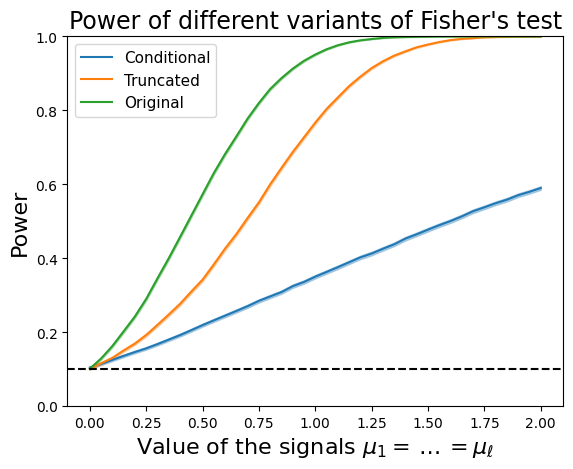

In [17]:
N = int(1e4)
n = 10 
ell = 10
alpha=0.1

mu_null = -2

tau = 0.5
k = 3
mus = np.arange(0, 2.05, step=0.05)

X = np.random.normal(0, 1, size=(N, n))

cond_power = np.zeros(len(mus))
trunc_power = np.zeros(len(mus))
orig_power = np.zeros(len(mus))

for i, mu in enumerate(mus):
    X_ = X.copy()
    X_[:, :ell] += mu
    X_[:, ell:] += mu_null 
    ps = 1 - norm.cdf(X_)
    ps = np.sort(ps, axis=1)

    orig_stats = -2*np.sum(np.log(ps), axis=1)
    orig_crit_val = chi2.ppf(1-alpha, df=2*n)
    orig_power[i] = np.mean(orig_stats > orig_crit_val)

    # conditional

    cond_stats = -2*np.sum(np.log(ps[:, :k]/ps[:, k].reshape(N, 1)), axis=1)
    cond_crit_val = chi2.ppf(1-alpha, df=2*k)
    cond_power[i] = np.mean(cond_stats > cond_crit_val)

    # trunc 

    below = ps < tau
    trunc_stats = -2*np.sum(np.log(ps/tau) * below, axis=1)
    num_selected = np.sum(below, axis = 1)
    trunc_crit_val = chi2.ppf(1-alpha, df=2*num_selected)
    trunc_power[i] = np.mean(trunc_stats > trunc_crit_val)



cond_std_dev = np.sqrt(cond_power * (1 - cond_power) / N)
cond_upper_bound = cond_power + cond_std_dev
cond_lower_bound = cond_power - cond_std_dev
plt.plot(mus, cond_power, label="Conditional", color='tab:blue')
plt.fill_between(mus, cond_lower_bound, cond_upper_bound, color='tab:blue', alpha=0.3)    

trunc_std_dev = np.sqrt(trunc_power * (1 - trunc_power) / N)
trunc_upper_bound = trunc_power + trunc_std_dev
trunc_lower_bound = trunc_power - trunc_std_dev
plt.plot(mus, trunc_power, label="Truncated", color='tab:orange')
plt.fill_between(mus, trunc_lower_bound, trunc_upper_bound, color='tab:orange', alpha=0.3)    

orig_std_dev = np.sqrt(orig_power * (1 - orig_power) / N)
orig_upper_bound = orig_power + orig_std_dev
orig_lower_bound = orig_power - orig_std_dev
plt.plot(mus, orig_power, label="Original", color='tab:green')
plt.fill_between(mus, orig_lower_bound, orig_upper_bound, color='tab:green', alpha=0.3)   

plt.xlabel("Value of the signals $\mu_1 = \dots = \mu_{\ell}$", fontsize=16)
plt.ylabel("Power", fontsize=16)
plt.title(f"Power of different variants of Fisher's test", fontsize=17)
plt.ylim([0,1])


plt.legend(fontsize=11)
plt.axhline(alpha, linestyle='--', color='black')

plt.savefig(f"fig/fisher_ell={ell}.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

### Gap Testing

In [ ]:
def B(alpha, n):
    return 1 - (1-alpha)**(1/n)

n = 20 
alpha = 0.05
N = int(1000) 
X = np.random.normal(0, 1, size=(N, n))

mu_signal = 3
mu_null = -3 

ks = np.arange(10)
class_power = np.zeros(len(ks))
cond_power = np.zeros(len(ks))
ratio_power = np.zeros(len(ks))
for i, k in enumerate(ks):
    mu = np.ones(n)
    mu[:k] *= mu_signal
    mu[k:] *= mu_null
    X += mu.reshape(1, n)
    ps = 1 - norm.cdf(X)

    ps = np.sort(ps, axis=1)

    class_reject = np.mean(ps[:, 0] <= B(alpha, n))
    cond_reject = np.mean(ps[:, 0]/ps[:, 1] <= alpha)

    ps_offset = np.zeros(ps.shape)
    ps_offset[: , :(n-1)] = ps[:, 1:].copy()
    ratios = ps/ps_offset 
    ratio_winners = np.argmin(ratios, axis=1)
    ratios[np.arange(N), ratio_winners] = np.inf
    second_ratios = np.min(ratios, axis=1)
    ps_offset = np.concatenat()
    ratio_winners += 1
    ratio_reject = ps[np.arange(N), ratio_winners] <= alpha * second_ratios * ps[np.arange(N), ratio_winners + 1] + (1-alpha)* ps[np.arange(N), ratio_winners - 1]
    ratio_power = np.mean(ratio_reject)


### Data Carving

False
False
False
False
False
True
False
False
False
False
False
True
True
False
False
False
False
False
False
True
False
False
False
False
True
True
True
True
False
True
True
False
True
False
False
False
False
False
False
True
True
False
True
False
True
True
True
True
True
True
False
False
True
False
True
True
False
False
False
False
True
False
False
True
False
False
True
True
False
False
False
False
False
True
False
True
True
True
True
True
False
True
False
True
True
True
False
True
False
False
False
False
True
True
True
True
False
True
False
False
True
False
True
True
False
True
False
False
True
True
False
False
False
True
True
False
False
False
True
True
False
True
False
True
True
False
False
True
True
False
True
False
False
False
False
False
False
False
True
True
False
True
False
False
True
False
True
True
False
False
False
False
False
True
False
True
True
True
False
True
False
True
True
True
False
True
False
False
True
False
True
True
False
False
True
True
True
False
False
False


(array([244., 267., 247., 260., 258., 249., 239., 271., 242., 250.]),
 array([1.60024625e-04, 1.00073080e-01, 1.99986136e-01, 2.99899191e-01,
        3.99812247e-01, 4.99725303e-01, 5.99638358e-01, 6.99551414e-01,
        7.99464469e-01, 8.99377525e-01, 9.99290580e-01]),
 <BarContainer object of 10 artists>)

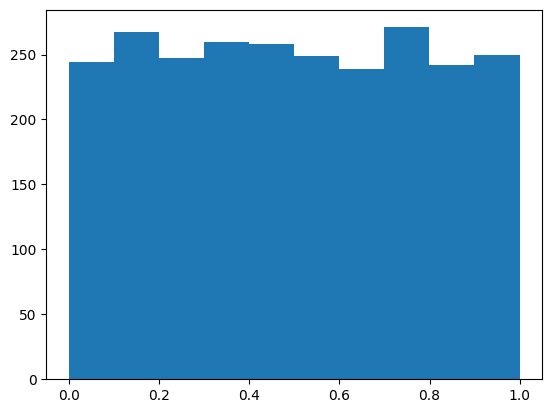

In [618]:
# Making sure it works 

N = 5000
t = 0

p_sels = []
ps = []
samples = []

def integrand(x, t):
   return 1 - norm.cdf(t - norm.ppf(1 - x)) 

for i in range(N):
    X1 = np.random.normal(0, 1) * np.sqrt(2)
    X2 = np.random.normal(0, 1) * np.sqrt(2)
    if X1 <= t:
        continue 
    X_bar = (X1 + X2)/2
    p = 1 - norm.cdf(X_bar)
    samples.append(X_bar)
    ps.append(p)
    num, error = integrate.quad(integrand, 0, p, args=(t,))
    #den = 1 - norm.cdf(t/np.sqrt(2))
    den, error = integrate.quad(integrand, 0, 1, args=(t,))
    p_sel = num/den
    p_sels.append(p_sel)
    p2 = 1 - norm.cdf(X2/np.sqrt(2))
    print(p_sel < p2)

plt.hist(p_sels, bins=10)

1.2463578360391974 -0.2738690404318556


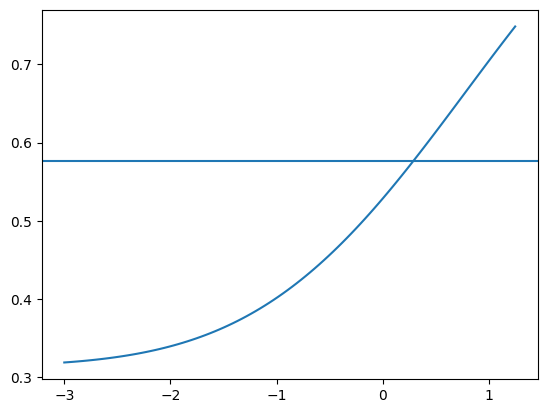

In [619]:
def integrand(x, t):
   return 1 - norm.cdf(t - norm.ppf(1 - x)) 

def compute_p_sel(p, t):
    num, error = integrate.quad(integrand, 0, p, args=(t,))
    den = 1 - norm.cdf(t/np.sqrt(2))
    return num/den 

ps = []
p2s = []

X1 = np.random.normal(0, 1) * np.sqrt(2)
X2 = np.random.normal(0, 1) * np.sqrt(2)
X_avg = (X1 + X2)/2
p = 1 - norm.cdf(X_avg)
p2 = 1 - norm.cdf(X2/np.sqrt(2))

print(X1, X2)

ts = np.linspace(-3, X1, 100)

plt.plot(ts, [compute_p_sel(p, t) for t in ts ])
plt.axhline(p2)


In [616]:
X1

np.float64(-1.0865326568854161)

In [611]:
X1

np.float64(0.6701176103084472)

In [64]:
def integrand(x):
   return 1 - norm.cdf(t - norm.ppf(1 - x)) 

def compute_p_sel(p, t):
    num, error = integrate.quad(integrand, 0, p)
    den = 1 - norm.cdf(t/np.sqrt(2))
    return num/den 

alpha = 0.1
n = 10

N=500
carve_error = 0 
split_error = 0
for i in tqdm(range(N)):

    X = np.random.normal(0, 1, size=n)
    X_split = np.zeros((n, 2))
    Z = np.random.normal(0, 1, size=n)
    X_split[:, 0] = X + Z
    X_split[:, 1] = X - Z

    order = np.argsort(-X_split[:, 0])
    X_split[:, 0] = X_split[order, 0]
    X_split[:, 1] = X_split[order, 1]
    X_avg = (X_split[:, 0] + X_split[:, 1])/2

    p2s = 1 - norm.cdf(X_split[:, 1]/np.sqrt(2)) 
    ps = 1 - norm.cdf(X_avg) 
    p_sels = np.zeros(n)
    for i in range(n-1):
        t = X_split[i + 1, 0]
        p_sels[i] = compute_p_sel(ps[i], t)
    p_sels[n-1] = ps[n-1]  
    print(p_sels[0] < p2s[0])


    carve_reject = (p_sels <= alpha)
    num_carve_reject = np.argmax(~carve_reject) if not carve_reject.all() else n
    if num_carve_reject > 0:
        carve_error += 1
    split_reject = (p2s <= alpha)
    num_split_reject = np.argmax(~split_reject) if not carve_reject.all() else n
    if num_split_reject > 0:
        split_error += 1





  1%|          | 3/500 [00:00<00:54,  9.16it/s]

False
False
False


  1%|          | 5/500 [00:00<01:00,  8.25it/s]

False
False
True


  2%|▏         | 10/500 [00:01<00:50,  9.64it/s]

False
True
True
False


  2%|▏         | 11/500 [00:01<00:59,  8.26it/s]

False
True


  3%|▎         | 16/500 [00:01<00:51,  9.37it/s]

False
False
False
False


  4%|▍         | 19/500 [00:02<00:55,  8.73it/s]

True
True
False


  5%|▍         | 23/500 [00:02<00:45, 10.45it/s]

False
True
False
True


  5%|▌         | 25/500 [00:02<00:47, 10.07it/s]

True
True
False
True


  6%|▌         | 31/500 [00:03<00:48,  9.76it/s]

False
False
False
False


  7%|▋         | 34/500 [00:03<00:48,  9.66it/s]

False
False
False
False


  8%|▊         | 38/500 [00:04<00:45, 10.10it/s]

False
True
False
False
False


  8%|▊         | 42/500 [00:04<00:45, 10.02it/s]

False
True
True


  9%|▉         | 46/500 [00:04<00:47,  9.54it/s]

False
False
True


 10%|▉         | 49/500 [00:05<00:44, 10.14it/s]

False
True
False
True


 11%|█         | 53/500 [00:05<00:43, 10.20it/s]

False
True
False
True
False


 12%|█▏        | 58/500 [00:06<00:48,  9.12it/s]

False
False
True


 12%|█▏        | 61/500 [00:06<00:49,  8.95it/s]

False
True
False
False


 13%|█▎        | 64/500 [00:06<00:45,  9.52it/s]

True
False


 13%|█▎        | 67/500 [00:07<00:49,  8.68it/s]

False
False
True


 14%|█▍        | 70/500 [00:07<00:45,  9.40it/s]

True
False
True


KeyboardInterrupt: 

In [63]:
split_error/N

0.11

### Car Engine: Real Data Analysis

In [766]:
# Exponential winner example 

def compute_exp_p(X, lamb):
    return expon.cdf(X, scale=1/lamb) 


def hybrid_CI(X, compute_p, theta_0, alpha=0.05, beta=0.005, eps=1e-8, step=1):
    
    n = len(X)

    beta_n = 1 - (1-beta)**(1/n)

    def obj(theta):
        ps = compute_p(X, theta)
        ps = np.sort(ps)
        return ps[0] - (alpha- beta)/(1-beta) * ps[1] - (1-alpha)/(1-beta) * beta_n
        #
    
    log_lower_guess = np.log(theta_0)
    log_upper_guess = np.log(theta_0)

    lower_obj_val = obj(np.exp(log_lower_guess))

    while lower_obj_val > 0:
        log_lower_guess -= step
        lower_obj_val = obj(np.exp(log_lower_guess))
 
    upper_obj_val = obj(np.exp(log_upper_guess))
    while upper_obj_val < 0:
        
        log_upper_guess += step
        upper_obj_val = obj(np.exp(log_upper_guess))

    log_middle_guess = (log_lower_guess + log_upper_guess)/2

    while np.abs(np.exp(log_upper_guess) - np.exp(log_lower_guess)) > eps:
        obj_val = obj(np.exp(log_middle_guess))
        if obj_val < 0:
            log_lower_guess = log_middle_guess
            log_middle_guess = (log_lower_guess + log_upper_guess)/2
        if obj_val > 0:
            log_upper_guess = log_middle_guess
            log_middle_guess = (log_lower_guess + log_upper_guess)/2

    return np.exp(log_lower_guess)



In [416]:
alpha =0.1
beta=0.01
lamb = np.array([0.01, 100])

X = np.random.exponential(1/lamb)
print(X)

lambda_hat_winner = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0)
lambda_hat_hybrid = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0.01)
lambda_hat_simul = hybrid_CI(X, compute_exp_p, 1, alpha=0.1, beta=0.1)

[5.32186362e+01 1.93451238e-02]


In [767]:
engine_df = pd.read_csv('engine.csv')
population_X = largest_ttf_per_id = engine_df.groupby('id')['ttf'].max().tolist()
population_X = np.array(population_X)

n = 2
N = 1000
alpha = 0.1

conditional = np.zeros(N)
#hybrid = np.zeros(N)
simultaneous = np.zeros(N)


for i in tqdm(range(N)):
    X = np.random.choice(population_X, n, replace=False)
    conditional[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=0)
    #hybrid[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=alpha/10)
    simultaneous[i] = hybrid_CI(X, compute_exp_p, 1, alpha=alpha, beta=alpha)


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_1041/4029692239.py:4: RuntimeWarning: overflow encountered in scalar divide
  return expon.cdf(X, scale=1/lamb)
100%|██████████| 1000/1000 [00:19<00:00, 52.36it/s]


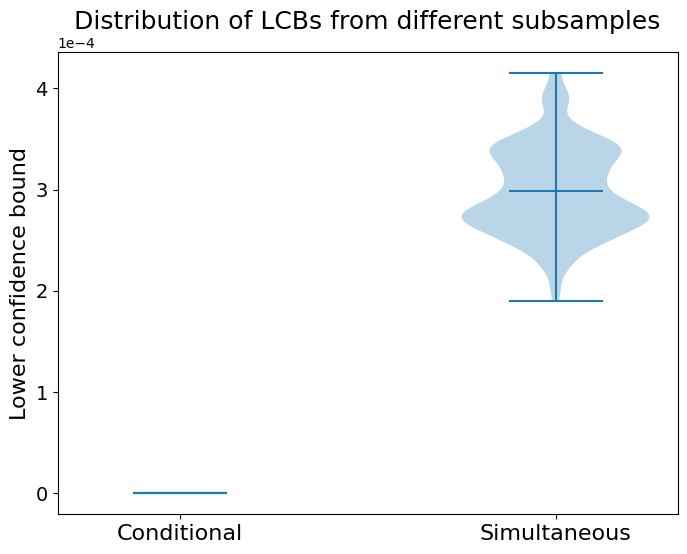

In [780]:
data = [conditional, simultaneous]
labels = ['Conditional', 'Simultaneous']

plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=True)

# Set labels for each plot
plt.xticks([1, 2], labels, fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Lower confidence bound', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
plt.title('Distribution of LCBs from different subsamples', fontsize=18)
plt.savefig(f"fig/car_eng.pdf")

### OSF Replication Analysis

47
92
39
34


/Users/anavsood/miniforge3/envs/seldom/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


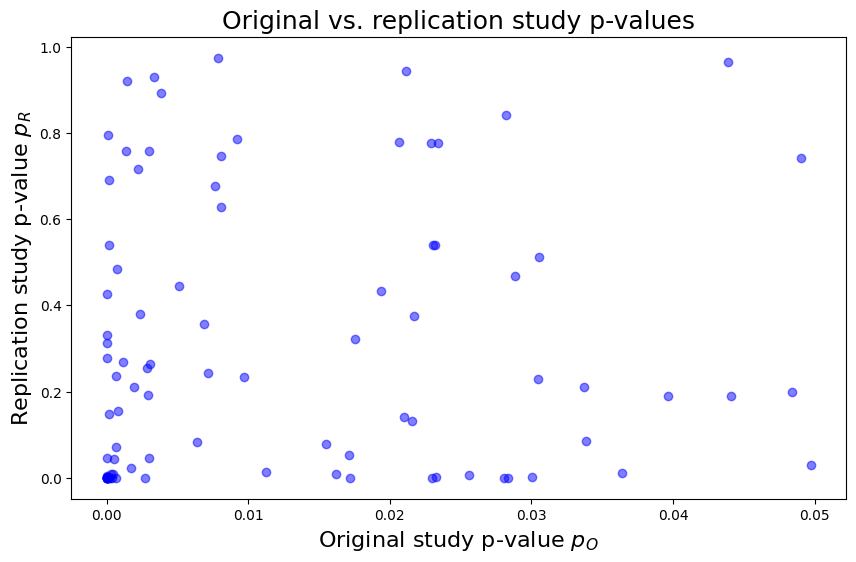

In [884]:
alpha=0.05

rpp_df = pd.read_csv('rpp_data.csv', encoding='latin1')

rpp_df = rpp_df[['T_pval_USE..O.', 'T_pval_USE..R.']]

# Display the first few rows of the new DataFrame

filtered_rpp_df = rpp_df[
    (rpp_df['T_pval_USE..O.'] < alpha) &
    (rpp_df['T_pval_USE..O.'].notna()) &
    (rpp_df['T_pval_USE..R.'].notna())
]

stats = -2 * (np.log(filtered_rpp_df['T_pval_USE..O.'] / 0.05) + np.log(filtered_rpp_df['T_pval_USE..R.']))
cutoff = chi2.ppf(1-alpha, df=4)

print(np.sum(stats > cutoff))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..O.'] < alpha)))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..O.'] < alpha**2)))
print(np.sum(np.asarray(filtered_rpp_df['T_pval_USE..R.'] < alpha)))

plt.figure(figsize=(10, 6))
plt.scatter(filtered_rpp_df['T_pval_USE..O.'], filtered_rpp_df['T_pval_USE..R.'], c='blue', alpha=0.5)


# Label the axes
plt.xlabel('Original study p-value $p_O$', fontsize=16)
plt.ylabel('Replication study p-value $p_R$', fontsize=16)

# Add a title and legend
plt.title('Original vs. replication study p-values', fontsize=18)
plt.savefig(f"replication.pdf")

In [866]:
np.sum(np.sort(filtered_rpp_df['T_pval_USE..O.']) < 0.0025)

np.int64(39)

In [549]:
combine_reject = np.where(stats > cutoff )[0]
second_reject = np.where(np.asarray(filtered_rpp_df['T_pval_USE..R.'] < alpha))[0]

combine_reject = set(combine_reject)
second_reject = set(second_reject)
print(len(second_reject.difference(combine_reject)) )

1


34

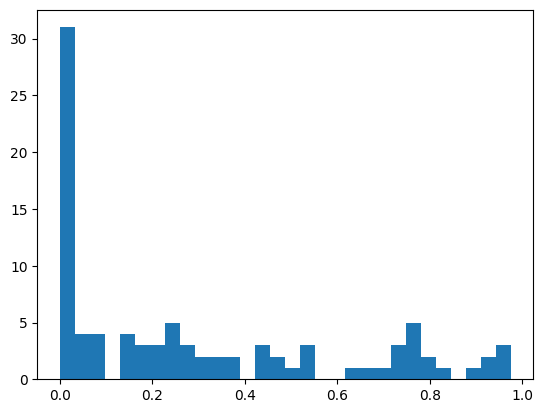

In [526]:
plt.hist(filtered_rpp_df['T_pval_USE..R.'], bins=30)
np.sum(filtered_rpp_df['T_pval_USE..R.'] < 0.05)

In [540]:
import numpy as np
from scipy.stats import norm, chi2, truncnorm

# Parameters
n_experiments = 10000  # Number of experiments
alpha = 0.05           # Significance level
mu = 2                 # Mean of the truncated normal and the second normal
threshold = chi2.ppf(1 - alpha, df=4)  # Chi-squared quantile for comparison

# Quantile for truncation
truncation_point = norm.ppf(0.95)  # 0.95 quantile for standard normal

# Define the truncated normal bounds for x1 with mean mu
a, b = (truncation_point - mu) / 1, np.inf  # Adjusted for mean `mu`

# Experiment counter for when statistic exceeds threshold
count_exceeds = 0

for _ in range(n_experiments):
    # Step 1: Sample x1 directly from a truncated normal distribution with mean mu
    x1 = truncnorm.rvs(a, b, loc=mu, scale=1)
    
    # Step 2: Sample x2 from a normal distribution with mean mu
    x2 = norm.rvs(loc=mu, scale=1)
    
    # Step 3: Compute p-values for each sample
    p1 = 1 - norm.cdf(x1)
    p2 = 1 - norm.cdf(x2)
    
    # Step 4: Compute the test statistic
    test_statistic = -2 * (np.log(p1 / 0.05) + np.log(p2))
    
    # Step 5: Check if the test statistic exceeds the chi-squared threshold
    if test_statistic > threshold:
        count_exceeds += 1

# Calculate the proportion of times the test statistic exceeded the threshold
proportion_exceeds = count_exceeds / n_experiments

print(f"Proportion of times the test statistic exceeded the threshold: {proportion_exceeds}")


Proportion of times the test statistic exceeded the threshold: 0.701


/var/folders/9b/8gtczpzd5_n_zlbsv10125gw0000gn/T/ipykernel_1041/1343001617.py:22: RuntimeWarning: divide by zero encountered in log
  test_statistic = -2 * (np.log(p1 / 0.05) + np.log(p2))


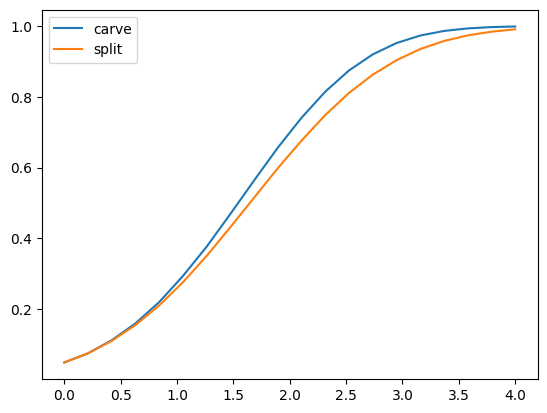

In [604]:
import numpy as np
from scipy.stats import norm, chi2, truncnorm

# Parameters
n_experiments = 1000000  # Number of experiments
alpha = 0.05           # Significance level
mus = np.linspace(0, 4, 20)                 # Mean of the truncated normal and the second normal
threshold = chi2.ppf(1 - alpha, df=4)  # Chi-squared quantile for comparison

# Quantile for truncation
truncation_point = norm.ppf(0.95)  # 0.95 quantile for standard normal

split_power = np.zeros(len(mus))
carve_power = np.zeros(len(mus))

for i, mu in enumerate(mus):
    a, b = (truncation_point - mu) / 1, np.inf  # Adjusted for mean `mu`
    x1 = truncnorm.rvs(a, b, loc=mu, scale=1, size=n_experiments)
    x2 = norm.rvs(loc=mu, scale=1, size=n_experiments)
    p1 = 1 - norm.cdf(x1)
    p2 = 1 - norm.cdf(x2)
    test_statistic = -2 * (np.log(p1 / alpha) + np.log(p2))
    carve_power[i] = np.mean(test_statistic > threshold)
    split_power[i] = np.mean(p2 < alpha)

plt.plot(mus, carve_power, label='carve')
plt.plot(mus, split_power, label='split')
plt.legend()

In [607]:
np.min(carve_power)

np.float64(0.049758)

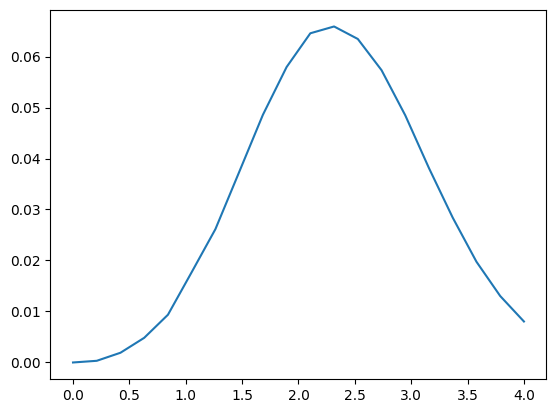

In [605]:

plt.plot(mus, carve_power - split_power, label='carve')

### Intro plots

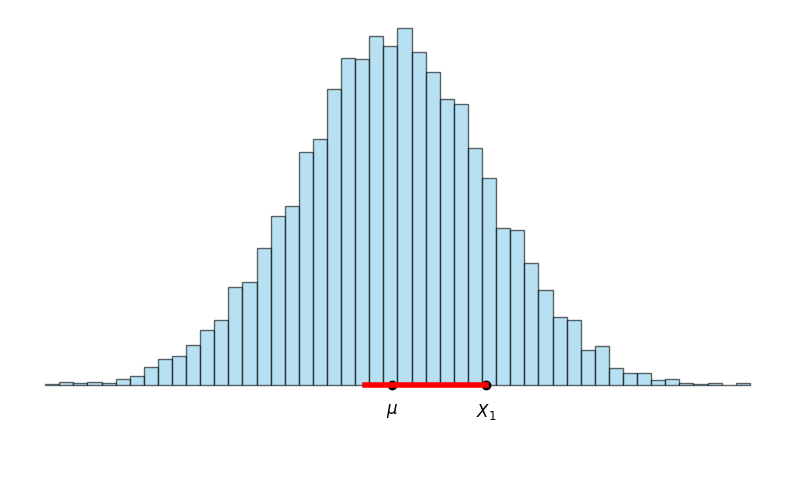

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0
std_dev = 1
num_samples = 10000

# Generate samples
samples = np.random.normal(mean, std_dev, num_samples)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Remove axis labels, ticks, title, and frame
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Adjust y-limits to shift the plot up
y_min, y_max = plt.gca().get_ylim()
plt.gca().set_ylim(y_min -0.1, y_max )  # Shifting up by roughly 1 cm in figure units

# Mark points on the x-axis and highlight region
plt.plot(0, 0, 'ko')  # Dot at x = 0
plt.text(0, y_min - 0.02, r'$\mu$', ha='center', va='top', fontsize=12)

X1= 1
plt.plot(X1, 0, 'ko')  # Dot at x = 1
plt.text(X1, y_min - 0.02, r'$X_1$', ha='center', va='top', fontsize=12)

# Highlight the x-axis from 0 to 1 in a thicker red line
plt.plot([X1-norm.ppf(0.90), X1], [0, 0], color='red', linewidth=4)
# Show plot
plt.show()



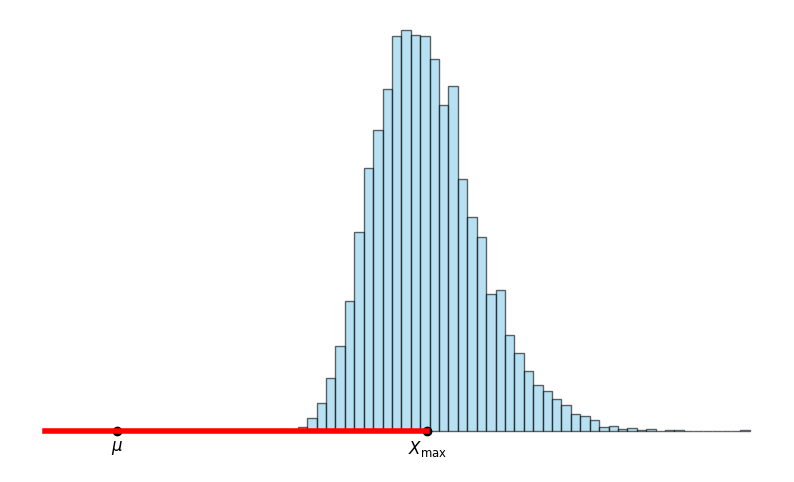

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0
std_dev = 1
num_samples = 10000

# Generate samples
n=100
samples = np.random.normal(mean, std_dev, (num_samples, n))
samples = np.max(samples, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Remove axis labels, ticks, title, and frame
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Adjust y-limits to shift the plot up
y_min, y_max = plt.gca().get_ylim()
plt.gca().set_ylim(y_min - 0.1, y_max )  # Shifting up by roughly 1 cm in figure units

# Mark points on the x-axis and highlight region
plt.plot(0, 0, 'ko')  # Dot at x = 0
plt.text(0, y_min - 0.02, r'$\mu$', ha='center', va='top', fontsize=12)

X1= 2.5
plt.plot(X1, 0, 'ko')  # Dot at x = 1
plt.text(X1, y_min - 0.02, r'$X_{\text{max}}$', ha='center', va='top', fontsize=12)

# Highlight the x-axis from 0 to 1 in a thicker red line
plt.plot([X1-norm.ppf((0.9)**(1/n)), X1], [0, 0], color='red', linewidth=4)
# Show plot
plt.show()


In [943]:
N =1000000
mu=-0.5

p = 1 - norm.cdf(np.random.normal(mu, 1, size=N))
U = np.random.uniform(0, 1, size=N)

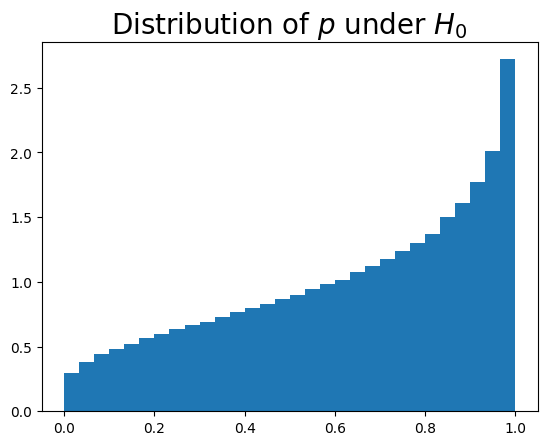

In [944]:
plt.hist(p, bins=30, density=True)
plt.title("Distribution of $p$ under $H_0$", fontsize=20)
#plt.axvline(0.5, color='tab:red')
plt.savefig(f"fig/p_dist.pdf")

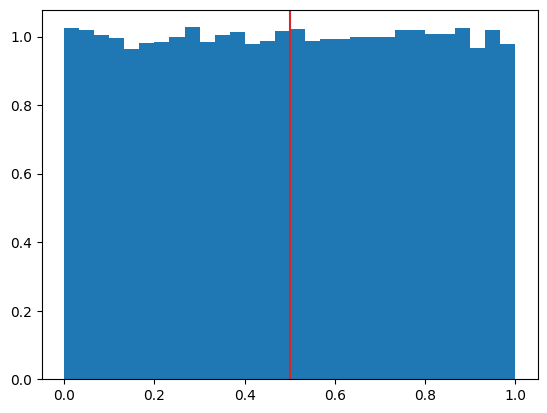

In [36]:
plt.hist(U, bins=30, density=True)
plt.axvline(0.5, color='tab:red')

In [945]:
N = 1000000

p = 1 - norm.cdf(truncnorm.rvs((norm.ppf(0.9) - mu) / 1, np.inf, loc=mu, scale=1, size=N))
U = np.random.uniform(0, 0.1, size=N)


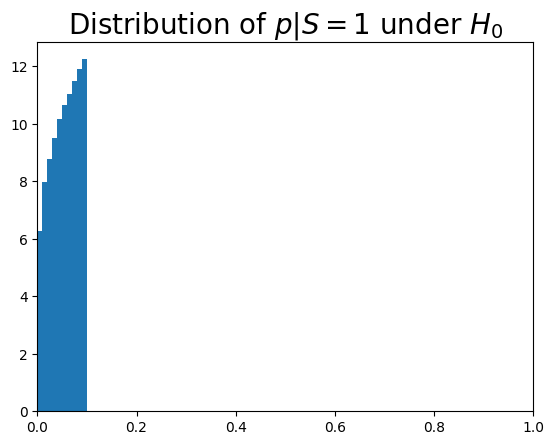

In [946]:
plt.hist(p, bins=10, density=True)
#plt.axvline(0.1, color='tab:red')
plt.title("Distribution of $p|S=1$ under $H_0$", fontsize=20)
plt.xlim([0, 1])
plt.savefig(f"fig/p_dist_given.pdf")

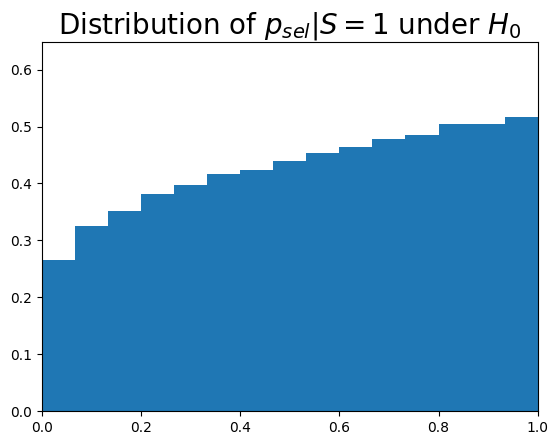

In [947]:
plt.hist(p/alpha, bins=30, density=True)
#plt.axvline(0.1, color='tab:red')
plt.title("Distribution of $p_{sel}|S=1$ under $H_0$", fontsize=20)
plt.xlim([0, 1])
plt.savefig(f"fig/p_sel_dist_given.pdf")

(0.0, 1.0)

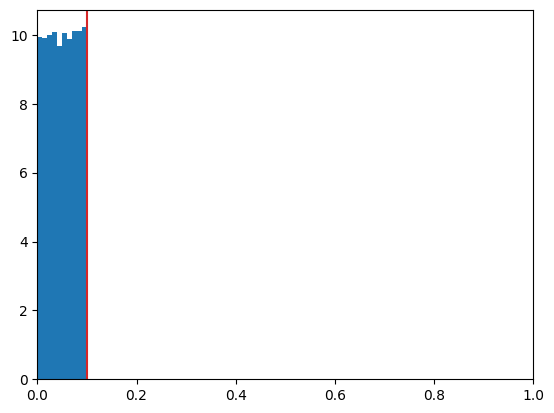

In [40]:
plt.hist(U, bins=10, density=True)
plt.axvline(0.1, color='tab:red')
plt.xlim([0, 1])

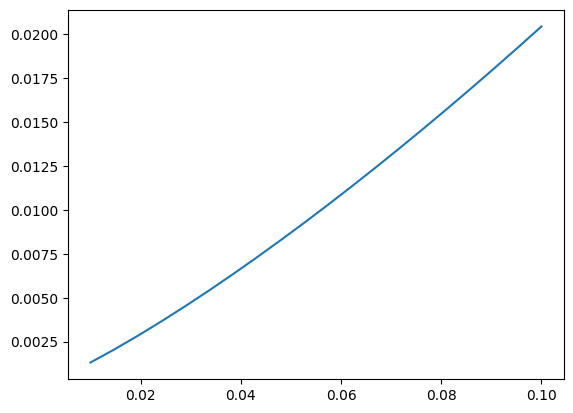

In [8]:
alphas = np.linspace(0.01, 0.1, 20)
alpha_adj = []
for alpha in alphas:
   alpha_adj.append(1 - chi2.cdf(chi2.ppf(1- alpha, df=4), df=2))

plt.plot(alphas, alpha_adj)